Import Library

In [1]:
# Import Pandas
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
import numpy as np
# Import plot
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import seaborn as sns

import Class_RFM_Queries as crfmq
rfm_q = crfmq.RFM_Queries()

Establish connection

In [2]:
%reload_ext google.cloud.bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:\\Users\\Cermati\\AppData\\Roaming\\gcloud\\application_default_credentials.json"
print(os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

C:\Users\Cermati\AppData\Roaming\gcloud\application_default_credentials.json


Get Data

In [3]:
_data = rfm_q.get_raw_data_user_segmentation_CLI()

C:\Users\Cermati\Anaconda3\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
# print(_data.head())
pd.set_option('display.max_rows', 60)
print(_data.dtypes)

applicantIdNumber                        object
first_score                              object
last_score                               object
firstAppChannel                          object
firstPartner                             object
firstproductType                         object
age_grouping                             object
applicantlasteducationlevel_grouping     object
type_of_jobs_grouping                    object
income_grouping                          object
spending_grouping                        object
income_minus_spending_grouping           object
partner_category                         object
users                                     int64
partner_count                             int64
cli_limit                                object
max_limit                                 int64
min_limit                                 int64
merchant_count                           object
merchant_list                            object
top_merchant                            

See Distribution

C:\Users\Cermati\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Cermati\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Cermati\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

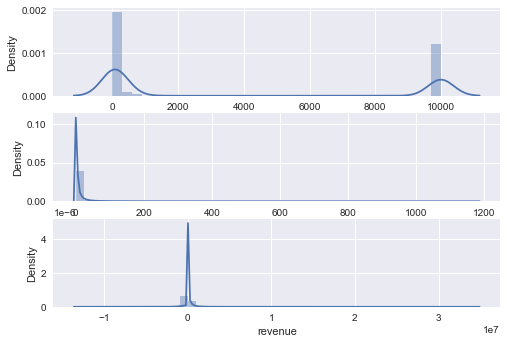

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.subplot(3,1,1)
sns.distplot(_data['day_since_last_approved'])
plt.subplot(3,1,2)
sns.distplot(_data['contracts'])
plt.subplot(3,1,3)
sns.distplot(_data['revenue'])
plt.show()

Pivot RFM

In [7]:
# Group by range of values
# _data.groupby(pd.cut(_data["day_since_last_approved"], np.arange(0, 600, 30))).users.sum()

# Group by range of values but with end point
# group_series = np.arange(0, 600, 30)
# group_series = np.append(group_series,[10000])
# _data.groupby(pd.cut(_data["day_since_last_approved"], group_series))['applicantIdNumber'].count()

In [6]:
# GROUP BY RECENCY
_data_groupby_recency = _data.groupby('day_since_last_approved').agg({'applicantIdNumber':'count'})#.sort_values(ascending=False)
# GROUP BY FREQUENCY
_data_groupby_frequency = _data.groupby('contracts').agg({'applicantIdNumber':'count'})#.sort_values(ascending=False)
# GROUP BY MONETIZATION
group_series = np.arange(100000, 20000000, 100000)
group_series = np.insert(group_series, 0, -50000000)
# Add 1st negative value of revenue
group_series = np.insert(group_series, 1, _data["revenue"][_data["revenue"]<0].max())
_data_groupby_monetization = _data.groupby(pd.cut(_data["revenue"], group_series)).agg({'applicantIdNumber':'count'})

# ADD RATE
_data_groupby_recency['rate'] = (100*_data_groupby_recency['applicantIdNumber']/ _data_groupby_recency['applicantIdNumber'].sum())
_data_groupby_recency['rate'] = _data_groupby_recency['rate'].round(2)

_data_groupby_frequency['rate'] = (100*_data_groupby_frequency['applicantIdNumber']/ _data_groupby_frequency['applicantIdNumber'].sum())
_data_groupby_frequency['rate'] = _data_groupby_frequency['rate'].round(2)

_data_groupby_monetization['rate'] = (100*_data_groupby_monetization['applicantIdNumber']/ _data_groupby_monetization['applicantIdNumber'].sum())
_data_groupby_monetization['rate'] = _data_groupby_monetization['rate'].round(2)

In [7]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 10)
# print(_data_groupby_recency)
# print(_data_groupby_frequency)
print(_data_groupby_monetization)

                      applicantIdNumber  rate
revenue                                      
(-50000000, -8]                   27219 10.03
(-8, 100000]                     179881 66.29
(100000, 200000]                  17388  6.41
(200000, 300000]                  11127  4.10
(300000, 400000]                   7599  2.80
...                                 ...   ...
(19400000, 19500000]                  0  0.00
(19500000, 19600000]                  0  0.00
(19600000, 19700000]                  0  0.00
(19700000, 19800000]                  0  0.00
(19800000, 19900000]                  0  0.00

[200 rows x 2 columns]


Function to set RFM class

In [8]:
def set_class(x) :
    recency_class = 0
    frequency_class = 0
    monetization_class = 0
    if x['day_since_last_approved'] < 10 :
        recency_class=3
    elif x['day_since_last_approved'] <= 31 :
        recency_class=2
    else :
        recency_class=1
        
    if x['contracts'] <= 3 :
        frequency_class=1
    elif x['contracts'] <= 10 :
        frequency_class=2
    else :
        frequency_class=3
    
    if x['revenue'] <= 200000 :
        monetization_class=1
    elif x['revenue'] <= 700000 :
        monetization_class=2
    else :
        monetization_class=3
        
    x['recency_class']=recency_class
    x['frequency_class']=frequency_class
    x['monetization_class']=monetization_class
    return x

In [9]:
_data = _data.apply(set_class,axis=1)

Scatter Plot

In [10]:
_data_test_scatter = _data.groupby(['recency_class','frequency_class','monetization_class']).agg({'applicantIdNumber':'count'})
# _data_test_scatter.reset_index()
# _data_test_scatter

In [11]:
_data_test_scatter.head()

applicantIdNumber
recency_class frequency_class monetization_class                   
1             1               1                              147091
                              2                                6564
                              3                                1589
              2               1                               17633
                              2                                4048

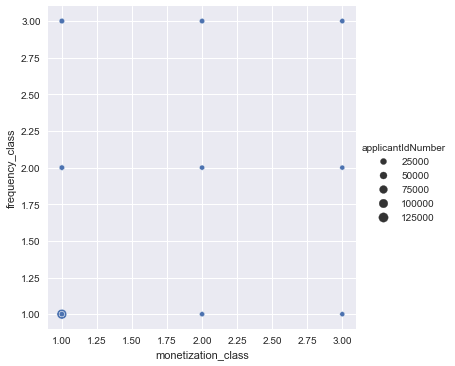

In [12]:
sns.relplot(x="monetization_class", y="frequency_class",size='applicantIdNumber', data=_data_test_scatter
           );